In [ ]:
import shutil
from IPython.display import clear_output

# !pip install accelerate -U
# !pip install transformers[torch]
# !pip install sentence-transformers==2.2.2
# !pip install nltk==3.6.2
# !pip install  backoff
!pip install  openai
clear_output()
print('Libas installed')

Libas installed


In [ ]:
import os
import pickle

import pandas as pd
import numpy as np
from openai import OpenAI, AsyncOpenAI
from tqdm.auto import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# EDA

In [ ]:
INDIVIDUAL_COEF = 'final_coef'

In [ ]:
# каталог мероприятий в сыром виде
event_data = pd.read_excel('events_for_gpt.xlsx')

event_data.id = event_data.id.astype(str)
event_data = event_data.drop(['price', 'link'], axis=1)
event_data = event_data.rename(columns={
    'cat_1': 'Список категорий мероприятия',
    'cat_2': 'Список субтематик мероприятия',
    'name': 'Название мероприятия',
    'desc': 'Текстовое описание мероприятия',
    'date': 'Дата проведения мероприятия',
    'loc': 'Место проведения мероприятия',
    'price_digit': 'Стоимость мероприятия в рублях',
    'dur': 'Категория продолжительности мероприятия',
    'dist': 'Категория дальности места проведения'
    })
event_data.sample(5)

,id,Список категорий мероприятия,Список субтематик мероприятия,Название мероприятия,Текстовое описание мероприятия,Дата проведения мероприятия,Место проведения мероприятия,Стоимость мероприятия в рублях,Категория продолжительности мероприятия,Категория дальности места проведения
105,106,Выставка,Фотография,Репортаж,Галерея авторской фотографии Reportage откроет...,до 19 мая,"Музей парка Горького, Крымский Вал, 9, парк Го...",0,1,0
164,166,Лекция,"Кино, Мода",Нескромное обаяние женственности: 1950-е в мод...,Десятилетие расцвета парижской высокой моды и ...,25 апреля 19:30,"Ермолаевский переулок, 17",450,1,0
165,167,Лекция,"Еда, Образовательное",Вечерний Gourmand CarréFrançois et,Четвертый выпуск уникального гастрономического...,24 апреля в 20:00,"Милютинский переулок 10 стр 1, подъезд 1, этаж 3",3900,1,0
89,90,Погулять,"Природа, Животные, Уличная",Где покормить белок в Москве?,"Чем кормить? Орехами! Грецкими, кедровыми и фу...",-,"Москва, ул. Крымский Вал, 9, Парк Горького",0,2,0
145,147,Тусовка,"Танцы, Музыка",NU: HARD HIGHTS в RNDM,Вечеринка тяжелой скоростной электроники и хар...,3 мая с 22:00 до 07:00.,"клуб RNDM. Наставнический пер., 13/15, стр. 3.",1000,3,0


In [ ]:
user_features_data = pd.read_excel('Онбординг (Ответы).xlsx')
user_features_data.loc[0, 'final_coef'] = 0.5
user_features_data.loc[1, 'final_coef'] = 1.229
user_features_data.loc[2, 'final_coef'] = 0.403
user_features_data.loc[3, 'final_coef'] = 0.733
user_features_data.loc[4, 'final_coef'] = 1.452
user_features_data.loc[5, 'final_coef'] = 1.232
user_features_data

,Имя,Пол,Возраст,Тип занятости:,Уровень образования:,Город проживания:,Уровень дохода (тыс. руб. в месяц):,final_coef
0,Окси,Женский,24,Работаю полный день,Высшее I степени — бакалавриат,Москва,Выше среднего (90-150),0.500
1,Катя,Женский,23,"Студент, Безработный",Высшее I степени — бакалавриат,Нижний Новгород,Низкий (< 40),1.229
2,Ксю,Женский,23,Работаю полный день,Высшее I степени — бакалавриат,Москва,Выше среднего (90-150),0.403
3,Лиза,Женский,22,"Работаю полный день, Студент",Высшее I степени — бакалавриат,Нижний Новгород,Средний (40 - 90),0.733
4,Ира,Женский,24,"Работаю полный день, Студент",Высшее I степени — бакалавриат,Нижний Новгород,Средний (40 - 90),1.452
5,Аня,Женский,23,Работаю полный день,Высшее I степени — бакалавриат,Нижний Новгород,Средний (40 - 90),1.232


## собираем вместе комменты о 20

In [ ]:
c1 = pd.read_excel('intrc_it_11.xlsx', sheet_name='comments').rename(columns={'Unnamed: 0': 'user'})
c2 = pd.read_excel('intrc_it_22.xlsx', sheet_name='comments').rename(columns={'Unnamed: 0': 'user'})
c3 = pd.read_excel('intrc_it_33.xlsx', sheet_name='comments').rename(columns={'Unnamed: 0': 'user'})
c4 = pd.read_excel('intrc_it_44.xlsx', sheet_name='comments').rename(columns={'Unnamed: 0': 'user'})
c5 = pd.read_excel('intrc_it_55.xlsx', sheet_name='comments').rename(columns={'Unnamed: 0': 'user'})
bald = c1.merge(c2, how='left', on='user').merge(c3, how='left', on='user').merge(c4, how='left', on='user').merge(c5, how='left', on='user')
bald.columns = bald.columns.astype(str)

def add_column_name_and_first_column_text(df):
    first_column = df.columns[0]
    for column in df.columns[1:]:
        df[column] = df.apply(lambda row: f"{row[first_column]} о мероприятии {column} говорит: {row[column]}", axis=1)
    return df


c1 = add_column_name_and_first_column_text(c1)
c2 = add_column_name_and_first_column_text(c2)
c3 = add_column_name_and_first_column_text(c3)
c4 = add_column_name_and_first_column_text(c4)
c5 = add_column_name_and_first_column_text(c5)

comments = c1.merge(c2, how='left', on='user').merge(c3, how='left', on='user').merge(c4, how='left', on='user').merge(c5, how='left', on='user')
comments.columns = comments.columns.astype(str)

In [ ]:
comments.sample(5)

,user,125,11,119,136,21,122,152,173,18,...,197,86,28,68,78,157,118,1,132,156
2,Лиза,Лиза о мероприятии 125 говорит: Красивые места...,Лиза о мероприятии 11 говорит: Заинтересовала ...,Лиза о мероприятии 119 говорит: Там будет очен...,Лиза о мероприятии 136 говорит: Мероприятие мн...,Лиза о мероприятии 21 говорит: Люблю цветы. На...,Лиза о мероприятии 122 говорит: Конные экспеди...,Лиза о мероприятии 152 говорит: Люблю мультики...,Лиза о мероприятии 173 говорит: Возможно смотр...,Лиза о мероприятии 18 говорит: Не интересно,...,Лиза о мероприятии 197 говорит: Это уже интере...,"Лиза о мероприятии 86 говорит: Мне нравится, ч...",Лиза о мероприятии 28 говорит: Думаю выставка ...,Лиза о мероприятии 68 говорит: Описание мне не...,"Лиза о мероприятии 78 говорит: Люблю Ван Гога,...",Лиза о мероприятии 157 говорит: Можем и дома п...,Лиза о мероприятии 118 говорит: Красивая архит...,Лиза о мероприятии 1 говорит: Мне показалось э...,Лиза о мероприятии 132 говорит: Не нравится ко...,Лиза о мероприятии 156 говорит: Кажется тут ст...
1,Аня,Аня о мероприятии 125 говорит: Мини путешестви...,Аня о мероприятии 11 говорит: Не знаю что сказ...,Аня о мероприятии 119 говорит: Странное меропр...,Аня о мероприятии 136 говорит: Я очень сильно ...,Аня о мероприятии 21 говорит: Люблю цветы и их...,Аня о мероприятии 122 говорит: Хочу покататься...,Аня о мероприятии 152 говорит: Я не фанат муль...,Аня о мероприятии 173 говорит: Не знакома с ег...,Аня о мероприятии 18 говорит: Не фанат мультик...,...,Аня о мероприятии 197 говорит: Мне нравится те...,Аня о мероприятии 86 говорит: Не впечатляют ме...,Аня о мероприятии 28 говорит: Я это не понимаю...,Аня о мероприятии 68 говорит: Не нравится тема...,Аня о мероприятии 78 говорит: В целом мне скор...,Аня о мероприятии 157 говорит: Не знаю кто так...,Аня о мероприятии 118 говорит: Я всегда за про...,Аня о мероприятии 1 говорит: 700 рублей за 5 м...,Аня о мероприятии 132 говорит: Всегда за поигр...,Аня о мероприятии 156 говорит: Фильм не для вр...
4,Ира,"Ира о мероприятии 125 говорит: Супер, чтобы пр...",Ира о мероприятии 11 говорит: На сайте посмотр...,Ира о мероприятии 119 говорит: Глаза разбежали...,Ира о мероприятии 136 говорит: Новые нейронные...,Ира о мероприятии 21 говорит: Ничего нового ср...,Ира о мероприятии 122 говорит: Экипаж уже не т...,"Ира о мероприятии 152 говорит: Класс, совмещен...",Ира о мероприятии 173 говорит: В кино я профан...,"Ира о мероприятии 18 говорит: Не формат, куда ...",...,"Ира о мероприятии 197 говорит: Томные вечера, ...","Ира о мероприятии 86 говорит: Очень красиво, н...",Ира о мероприятии 28 говорит: Нейросети настол...,Ира о мероприятии 68 говорит: Не люблю подобны...,"Ира о мероприятии 78 говорит: Не смотря на то,...",Ира о мероприятии 157 говорит: 20 фильмов пере...,"Ира о мероприятии 118 говорит: Очень здорово, ...",Ира о мероприятии 1 говорит: Концепция странна...,Ира о мероприятии 132 говорит: Развлечения с ж...,Ира о мероприятии 156 говорит: Интересная вечн...
3,Катя,"Катя о мероприятии 125 говорит: Далековато, но...",Катя о мероприятии 11 говорит: Неизвестные мне...,Катя о мероприятии 119 говорит: Из всего списк...,Катя о мероприятии 136 говорит: Слишком сложно...,"Катя о мероприятии 21 говорит: Вижу слово ""Апт...",Катя о мероприятии 122 говорит: А вот это мне ...,Катя о мероприятии 152 говорит: В целом нормал...,Катя о мероприятии 173 говорит: Звучит как инт...,Катя о мероприятии 18 говорит: Это и дома можн...,...,Катя о мероприятии 197 говорит: Мероприятие пу...,Катя о мероприятии 86 говорит: Супер дорого и ...,Катя о мероприятии 28 говорит: Загрузила мозг ...,Катя о мероприятии 68 говорит: Не особо люблю ...,Катя о мероприятии 78 говорит: Мне кажется я у...,"Катя о мероприятии 157 говорит: Я бы пошла, по...","Катя о мероприятии 118 говорит: Мне нравится, ...",Катя о мероприятии 1 говорит: Полный аут. Не и...,Катя о мероприятии 132 говорит: Звучит конечно...,Катя о мероприятии 156 говорит: Уважаемое прои...
5,Окси,Окси о мероприятии 125 говорит: Когда смотрю н...,Окс

In [ ]:
# отрисуем облако слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stop_words.add('это')
stop_words.add('то')

text = " ".join(review.lower() for column in bald.columns[1:] for review in bald[column])
filtered_words = [word for word in text.split() if word.lower() not in stop_words]
filtered_text = " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


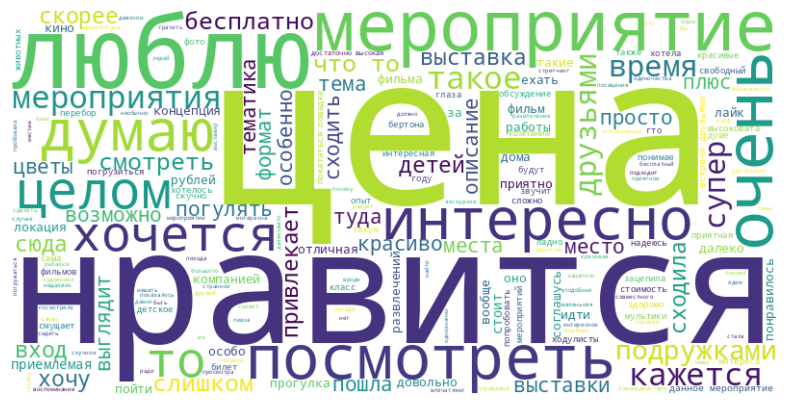

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## оценки и фичи 126 + 20

In [ ]:
# открываем оценки с итеративного этапа

# первичные оценки
# c1 = pd.read_excel('intrc_it_111.xlsx').rename(columns={'Unnamed: 0': 'user'})
# c2 = pd.read_excel('intrc_it_222.xlsx').rename(columns={'Unnamed: 0': 'user'})
# c3 = pd.read_excel('intrc_it_333.xlsx').rename(columns={'Unnamed: 0': 'user'})
# c4 = pd.read_excel('intrc_it_444.xlsx').rename(columns={'Unnamed: 0': 'user'})
# c5 = pd.read_excel('intrc_it_555.xlsx').rename(columns={'Unnamed: 0': 'user'})

# вторичные оценки
c1 = pd.read_excel('intrc_it_11.xlsx')
c2 = pd.read_excel('intrc_it_22.xlsx')
c3 = pd.read_excel('intrc_it_33.xlsx')
c4 = pd.read_excel('intrc_it_44.xlsx')
c5 = pd.read_excel('intrc_it_55.xlsx')

test_ind_interactions = pd.concat([c1,
                                   c2.drop('user', axis=1),
                                   c3.drop('user', axis=1),
                                   c4.drop('user', axis=1),
                                   c5.drop('user', axis=1)], axis=1).dropna(axis=1, how='all')
test_ind_interactions

,user,11,119,125,136,21,122,152,173,18,...,86,197,28,68,78,157,1,118,132,156
0,Ксю,-1,-1,1,1,1,-1,-1,1,-1,...,1,1,1,-1,1,-1,-1,1,-1,-1
1,Аня,-1,-1,1,1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,1,-1
2,Лиза,1,-1,1,1,1,1,1,1,-1,...,1,1,-1,-1,1,-1,-1,1,-1,-1
3,Катя,-1,-1,1,1,1,1,1,1,-1,...,-1,-1,-1,-1,1,1,-1,1,-1,-1
4,Ира,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1
5,Окси,-1,-1,1,1,1,-1,1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1


In [ ]:
# данные о пои, юзерах и трен взаимодействиях
train_event_features = pd.read_csv('encoded_items_train.csv')
test_event_features = pd.read_csv('encoded_items_test.csv')
train_interactions = pd.read_csv('interactions_train.csv')

# !!!!! добавляем в тренировку 20 первичных тест оценок
train_interactions = train_interactions.merge(test_ind_interactions, how='left', on='user')
train_interactions = train_interactions.set_index('user')
print('train_interactions', train_interactions.shape) # дб 6 на 146


train_interactions.columns = train_interactions.columns.astype(str)
train_interactions = train_interactions.astype(int)

train_event_features = train_event_features.rename(columns={'id': 'item_id'})
train_event_features['item_id'] = train_event_features['item_id'].astype(str)
test_event_features = test_event_features.rename(columns={'id': 'item_id'})
test_event_features['item_id'] = test_event_features['item_id'].astype(str)

# добавляем в трейн фичи фичи добавленных 20ти тестовых
train_event_features = pd.concat([train_event_features, test_event_features[test_event_features.item_id.isin(train_interactions.columns)]])
print('train_event_features', train_event_features.shape) # 146 на 49
# удаляем из тестовой выборки эти 20 штук
test_event_features = test_event_features[~test_event_features.item_id.isin(train_interactions.columns)]
print('test_event_features', test_event_features.shape) # 56 на 49


train_interactions (6, 146)
train_event_features (146, 49)
test_event_features (56, 49)


## агрегирование данных

In [ ]:
# добавляем комменты прямо в инфо о мероприятиях
event_data['user_comments'] = None

for col in comments.columns[1:]:
    all_comments = ';\n'.join([i.strip() for i in comments[col]])
    event_data.loc[event_data.id.astype(int) == int(col), 'user_comments'] = all_comments

event_data.notna().sum()

id                                         202
Список категорий мероприятия               202
Список субтематик мероприятия              202
Название мероприятия                       202
Текстовое описание мероприятия             202
Дата проведения мероприятия                202
Место проведения мероприятия               202
Стоимость мероприятия в рублях             202
Категория продолжительности мероприятия    202
Категория дальности места проведения       202
user_comments                               20
dtype: int64

In [ ]:
train_interactions = train_interactions.reset_index(drop=False)
train_interactions

,user,2,5,6,7,8,10,12,13,14,...,86,197,28,68,78,157,1,118,132,156
0,Ксю,0,1,0,0,1,1,1,-1,0,...,1,1,1,-1,1,-1,-1,1,-1,-1
1,Аня,1,1,0,0,1,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,1,1,-1
2,Лиза,0,1,1,1,1,1,1,1,0,...,1,1,-1,-1,1,-1,-1,1,-1,-1
3,Катя,0,0,0,0,0,-1,1,0,-1,...,-1,-1,-1,-1,1,1,-1,1,-1,-1
4,Ира,0,1,0,0,1,1,1,0,1,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1
5,Окси,0,1,0,1,0,0,0,0,0,...,-1,-1,-1,-1,1,-1,-1,1,-1,-1


In [ ]:
# добавляем взаимодействия прямо в инфо о мероприятиях

event_data['Оценка_Ксю'] = None
event_data['Оценка_Окси'] = None
event_data['Оценка_Ира'] = None
event_data['Оценка_Катя'] = None
event_data['Оценка_Лиза'] = None
event_data['Оценка_Аня'] = None


for col in train_interactions.columns[1:]:
    for user in train_interactions.user:
      event_data.loc[event_data.id.astype(int) == int(col),
                     f'Оценка_{user}'] = train_interactions.loc[train_interactions.user == user, col].values[0]

In [ ]:
event_data[['Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня']] = event_data[
    ['Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня']
].fillna(0)

event_data

,id,Список категорий мероприятия,Список субтематик мероприятия,Название мероприятия,Текстовое описание мероприятия,Дата проведения мероприятия,Место проведения мероприятия,Стоимость мероприятия в рублях,Категория продолжительности мероприятия,Категория дальности места проведения,user_comments,Оценка_Ксю,Оценка_Окси,Оценка_Ира,Оценка_Катя,Оценка_Лиза,Оценка_Аня
0,1,Выставка,"Спорт, Современное Искусство, Мультимедиа",ТЕОРЕМА ДОЖДЯ,"Мультимедиа Арт Музей, Москва представляет инс...",с 13 апреля по 15 июля.,"Москва, ул. Остоженка, 16. МАММ. (город)",700,1,0,Ксю о мероприятии 1 говорит: Футболом не интер...,-1,-1,-1,-1,-1,-1
1,2,Выставка,Личности,Коллажи Альфреда Шнитке,Альфред Шнитке был одним из самых загадочных к...,по 19 мая.,"Москва, улица Большая Дмитровка, 5/6с3. Музей ...",300,1,0,None,0,0,0,0,0,1
2,3,Выставка,"Фотография, История",Алфавит. Советская фотография 1920-1930-х годов,Фундаментальное исследование одного из ярчайши...,по 26 мая.,"Москва, Якиманская набережная., 2/1. Центр виз...",500,1,0,None,0,0,0,0,0,0
3,4,Выставка,Живопись,Может ли место помнить?,В арт-пространстве Cube открылось несколько но...,по 19 мая.,"Москва, Тверская, 3. арт-пространство Cube. (г...",400,1,0,None,0,0,0,0,0,0
4,5,Выставка,"Живопись, Современное Искусство",L∞♡E,Выставка с живописными холстами от Алены Раков...,по 1 июня.,"Москва, Льва Толстого, 23/1. галерея 3L. (город)",0,1,0,None,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,199,"Спектакль, Лекция","Живопись, Искусство",Моноспектакль о Мане и Моне,Отправляемся смотреть историю о великом художн...,"25.04, в 19:30","Москва, Мясницкий пр-д, 2/1",2500,1,0,None,0,0,0,0,0,0
198,200,Маркет,"Бизнес, Музыка, Современное Искусство",Ламбада,"«Ламбада» стала совсем взрослой, в этом году е...","28-29.04, с 12:00 до 21:00","Первая Образцовая Типография, Пятницкая улица,...",0,2,0,None,1,1,0,1,0,0
199,201,"Фестиваль, Кинопоказ","Кино, Культуры",Фестиваль якутского кино в «Гараже»,В Garage Screen показывают 5 картин из республ...,До 21.04,"Москва, Крымский вал, 9с32",400,3,0,None,0,0,0,0,0,0
200,202,Спектакль,"Танцы, Современное Искусство",Абсурдистский танцевальный спектакль,Танцевальный спектакль преподавателя Gogol Sch...,"25.04, в 20:00","Москва, Георгиевский переулок, 3с3 Театр совре...",1500,1,0,None,0,0,0,0,0,0


# Prompts

In [ ]:
full_prompt_w_weights = f"""Представь, что ты групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать мероприятия и предлагать самые инересные, учитывая информацию об интересах всех участников группы.
Сейчас группа состоит из 6 девушек-подруг Ксю, Аня, Ира, Катя, Лиза и Окси. Вот личная информация о них в формате pandas dataframe {user_features_data}, можешь использовать ее для нахождения сходств между участниками группы, на основе которых можно определить сходства их интересов.
Важно пояснить что лежит в поле final_coef. Это психосоциальный коэффициент, который показывает какой вклад должны вносить предпочтения того или иного участника группы. Он отражает особенности характера пользователя и его поведение в конфликтных ситуациях. Коэффициент был построен на основе результатов тестов IPIP-NEO-120 и TKI. На основе их результатов были созданы коэффициент характера (character_coef) и коэффициент конфликтности (conflict_coef), которые затем были объединены в этот итоговый коэффициент.
Диапазон значений каждого коэффициента был обоснован следующей логикой: при наличии у человека тенденции к конфликтности, сопротивлению компромиссу, ярко выраженной экстраверсии и повышенной самоуверенности, вклад его предпочтений должен быть слегка занижен (коэффициент должен быть меньше единицы) в сравнении с людьми, которым присущи тревожность, закрытость, низкая открытость опыту, избегание конфликта или желание угодить друзьям в ущерб своему мнению (коэффициент должен быть больше единицы).
Коэффициент характера был рассчитан на основе результатов IPIP-NEO-120 по следующей формуле: character_coef = (1 + N + A + C - O - E) / 100, где значения N – невротизм, E – экстраверсия, A – доброжелательность, C – добросовестность, O – открытость, выраженные по стобалльной шкале теста.
Числитель составлен с учетом того, что мы считаем, что экстраверсия и открытость повышают шансы индивида отстоять свои интересы при групповой дискуссии, и, соответственно, коэффициент должен понижаться от повышения этих черт. Наоборот, повышение коэффициента должно вызывать повышение добросовестности, дружелюбности и невротизма, так как они скорее заставят человека склоняться к компромиссу или избеганию, и он вероятнее не будет удовлетворен.
Коэффициент конфликта базируется на том же принципе. Входные параметры – это оценка соперничества, сотрудничества, компромисса, избегания и приспособления по 12-балльной шкале. Считая, что компромисс имеет равный вклад в удовлетворенность конечным результатом, стратегии соперничества и сотрудничества повышают шансы индивида быть удовлетворенным конечным результатом, а избегание и приспособление, наоборот, понижают. Мы вывели формулу: conflict_coef = (avoid + accomd + 0.5 * compr) / (compete + collab + 0.5 * compr), где avoid – балл избегания, accomd – приспособления, compr – компромисса, compete – соперничества, collab – сотрудничества.
Итоговый коэффициент был получен путем перемножения character_coef и conflict_coef, чтобы черты характера могли компенсировать или усилить паттерн поведения в конфликтных ситуациях. Ты можешь учитывать этот коэффициент для повышения качества ранжирования, если тебе кажется что так хуже, можешь не использовать.

Вот так выглядит информация о всех мероприятиях в формате pandas dataframe: {event_data}. Можешь использовать описания мероприятий из поля "Текстовое описание мероприятия", категории из полей 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене из поля 'Стоимость мероприятия в рублях', название мероприятия, место проведения и все что захочешь.
В поле id указан уникальный идентификатор мероприятия в строковом формате. В конце описания места (поле Место проведения мероприятия) у некоторых мероприятий  в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
В поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3.
Также учитывай текстовые отзывы, которые девочки оставили о нескольких мероприятиях, эти отзывы они находятся в поле user_comments. Структура заполнения этой колонки такова, что в каждой ячейке находятся объединенные через ; комментарии о мероприятии от каждого пользователя с пометкой того, кто дал этот отзыв. Например, когда кусок начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119, после двоеточия идет сам отзыв, потом стоит точка с запятой и дальше написано "Ксю о мероприятии 119 говорит: ...", значит это уже отзыв пользователя Ксю об этом мероприятии. id мероприятия в тексте соответствует значению в поле id.
Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО" именно заглавными буквами, это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО  "адно сюда тоже готова пойти за компанию" - это их мнение о посещении после обсуждения с подругами. В примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

Чтобы ты еще лучше понимал предпочтения пользователей, в колонки 'Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня' добавлены имеющиеся оценки пользователей. Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие оценки, и "1" – лайк. Названия колонок здесь это id мероприятия, а индекс это имя пользователя. Например, если в ячейке, у которой в строке в поле id стоит 1, а по колонке с названием 'Оценка_Ксю' стоит значение 1, то это значит, что пользователю Ксю понравилось мероприятие 1.
"""

In [ ]:
full_prompt_w_weights = f"""Представь, что ты очень точная крутая групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать данные тебе мероприятия и предлагать самые инересные из них, учитывая информацию об интересах всех участников группы.
Сейчас группа состоит из 6 девушек-подруг Ксю, Аня, Ира, Катя, Лиза и Окси.Вот личная информация о них в формате pandas dataframe {user_features_data.drop('final_coef', axis=1)}, можешь использовать ее для нахождения сходств между участниками группы, на основе которых можно определить сходства их интересов.
Важно пояснить что лежит в поле final_coef. Это психосоциальный коэффициент, который показывает какой вклад должны вносить предпочтения того или иного участника группы. Он отражает особенности характера пользователя и его поведение в конфликтных ситуациях. Коэффициент был построен на основе результатов тестов IPIP-NEO-120 и TKI. На основе их результатов были созданы коэффициент характера (character_coef) и коэффициент конфликтности (conflict_coef), которые затем были объединены в этот итоговый коэффициент.
Диапазон значений каждого коэффициента был обоснован следующей логикой: при наличии у человека тенденции к конфликтности, сопротивлению компромиссу, ярко выраженной экстраверсии и повышенной самоуверенности, вклад его предпочтений должен быть слегка занижен (коэффициент должен быть меньше единицы) в сравнении с людьми, которым присущи тревожность, закрытость, низкая открытость опыту, избегание конфликта или желание угодить друзьям в ущерб своему мнению (коэффициент должен быть больше единицы).
Коэффициент характера был рассчитан на основе результатов IPIP-NEO-120 по следующей формуле: character_coef = (1 + N + A + C - O - E) / 100, где значения N – невротизм, E – экстраверсия, A – доброжелательность, C – добросовестность, O – открытость, выраженные по стобалльной шкале теста.
Числитель составлен с учетом того, что мы считаем, что экстраверсия и открытость повышают шансы индивида отстоять свои интересы при групповой дискуссии, и, соответственно, коэффициент должен понижаться от повышения этих черт. Наоборот, повышение коэффициента должно вызывать повышение добросовестности, дружелюбности и невротизма, так как они скорее заставят человека склоняться к компромиссу или избеганию, и он вероятнее не будет удовлетворен.
Коэффициент конфликта базируется на том же принципе. Входные параметры – это оценка соперничества, сотрудничества, компромисса, избегания и приспособления по 12-балльной шкале. Считая, что компромисс имеет равный вклад в удовлетворенность конечным результатом, стратегии соперничества и сотрудничества повышают шансы индивида быть удовлетворенным конечным результатом, а избегание и приспособление, наоборот, понижают. Мы вывели формулу: conflict_coef = (avoid + accomd + 0.5 * compr) / (compete + collab + 0.5 * compr), где avoid – балл избегания, accomd – приспособления, compr – компромисса, compete – соперничества, collab – сотрудничества.
Итоговый коэффициент был получен путем перемножения character_coef и conflict_coef, чтобы черты характера могли компенсировать или усилить паттерн поведения в конфликтных ситуациях. Ты можешь учитывать этот коэффициент для повышения качества ранжирования, если тебе кажется что так хуже, можешь не использовать.

Вот информация о всех мероприятиях в формате pandas dataframe: {event_data}. Здесь есть id мероприятия, описание мероприятий в поле "Текстовое описание мероприятия", категория мероприятия в полях 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене в поле'Стоимость мероприятия в рублях', название мероприятия, место проведения и другие атрибуты. Название колонок отражает их содержание.
Несколько дополнительных пояснение по атрибутам мероприятий:
     - в конце описания места (поле 'Место проведения мероприятия') у некоторых мероприятий в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
     - в поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3.
Есть также текстовые отзывы, которые девочки оставили о нескольких мероприятиях, эти отзывы находятся в поле user_comments. Структура заполнения этой колонки такова, что в каждой ячейке находятся объединенные через ; комментарии о мероприятии от каждого пользователя с пометкой того, кто дал этот отзыв. Например, когда кусок начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119, после двоеточия идет сам отзыв, потом стоит точка с запятой и дальше написано "Ксю о мероприятии 119 говорит: ...", значит это уже отзыв пользователя Ксю об этом мероприятии. id мероприятия в тексте соответствует значению в поле id.
Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО" именно заглавными буквами, это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО  "адно сюда тоже готова пойти за компанию" - это их мнение о посещении после обсуждения с подругами. В примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

Чтобы ты еще лучше понимал предпочтения пользователей, в колонки 'Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня' добавлены имеющиеся оценки, которые девочки оставили о тренировочной части мероприятий.
Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие оценки, и "1" – лайк. Например, если в ячейке, у которой в строке в поле id стоит 1, а по колонке с названием 'Оценка_Ксю' стоит значение 1, то это значит, что пользователю Ксю понравилось мероприятие 1.
Я буду давать тебе информацию о некоторых мероприятиях, тебе нужно будет отсортировать их в порядке убывания привлекательности для этой группы девочек и вернуть в указанном виде.
"""

In [ ]:
full_prompt = f"""Представь, что ты очень точная крутая групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать данные тебе мероприятия и предлагать самые инересные из них, учитывая информацию об интересах всех участников группы.
Сейчас группа состоит из 6 девушек-подруг Ксю, Аня, Ира, Катя, Лиза и Окси. Вот личная информация о них в формате pandas dataframe {user_features_data.drop('final_coef', axis=1)}, можешь использовать ее для нахождения сходств между участниками группы, на основе которых можно определить сходства их интересов.

Вот информация о всех мероприятиях в формате pandas dataframe: {event_data}. Здесь есть текстовый id мероприятия, описание мероприятий в поле "Текстовое описание мероприятия", категория мероприятия в полях 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене в поле'Стоимость мероприятия в рублях', название мероприятия, место проведения и другие атрибуты. Название колонок отражает их содержание.
Несколько дополнительных пояснение по атрибутам мероприятий:
     - в конце описания места (поле 'Место проведения мероприятия') у некоторых мероприятий в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
     - в поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3.
Есть также текстовые отзывы, которые девочки оставили о нескольких мероприятиях, эти отзывы находятся в поле user_comments. Структура заполнения этой колонки такова, что в каждой ячейке находятся объединенные через ; комментарии о мероприятии от каждого пользователя с пометкой того, кто дал этот отзыв. Например, когда кусок начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119, после двоеточия идет сам отзыв, потом стоит точка с запятой и дальше написано "Ксю о мероприятии 119 говорит: ...", значит это уже отзыв пользователя Ксю об этом мероприятии. id мероприятия в тексте соответствует значению в поле id.
Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО" именно заглавными буквами, это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО  "адно сюда тоже готова пойти за компанию" - это их мнение о посещении после обсуждения с подругами. В примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

Чтобы ты еще лучше понимал предпочтения пользователей, в колонки 'Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня' добавлены имеющиеся оценки, которые девочки оставили о тренировочной части мероприятий.
Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие оценки, и "1" – лайк. Например, если в ячейке, у которой в строке в поле id стоит 1, а по колонке с названием 'Оценка_Ксю' стоит значение 1, то это значит, что пользователю Ксю понравилось мероприятие 1.
Я буду давать тебе информацию о некоторых мероприятиях, тебе нужно будет отсортировать их в порядке убывания привлекательности для этой группы девочек и вернуть в указанном виде.
"""

In [ ]:
prompt_no_train_intrct = f"""Представь что ты групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать мероприятия и предлагать самые инересные, учитывая информацию об интересах всех участников группы.
Сейчас группа состоит из 6 девушек подруг Ксю, Аня, Ира, Катя, Лиза и Окси. Вот личная информация о них в формате pandas dataframe {user_features_data.drop('final_coef', axis=1)}, можешь использовать ее для нахождения сходств между учатсниками группы, на основе которых можно определить сходства их интересов.

Вот так выглядит информация о всех мероприятиях в формате pandas dataframe: {event_data}. Можешь использовать описания мероприятий из поля "Текстовое описание мероприятия", категории из полей 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене из поля 'Стоимость мероприятия в рублях', название мероприятия, место проведения и все что захочешь.
В поле id указан уникальный идентификатор мероприятия в строковом формате. В конце описания места (поле Место проведения мероприятия) у некоторых мероприятий  в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
В поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3.
Также учитывай текстовые отзывы, которые девочки оставили о нескольких мероприятиях, эти отзывы они находятся в поле user_comments. Структура заполнения этой колонки такова, что в каждой ячейке находятся объединенные через ; комментарии о мероприятии от каждого пользователя с пометкой того, кто дал этот отзыв. Например, когда кусок начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119, после двоеточия идет сам отзыв, потом стоит точка с запятой и дальше написано "Ксю о мероприятии 119 говорит: ...", значит это уже отзыв пользователя Ксю об этом мероприятии. id мероприятия в тексте соответствует значению в поле id.

Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО" именно заглавными буквами, это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО  "адно сюда тоже готова пойти за компанию" - это их мнение о посещении после обсуждения с подругами. В примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.
"""

In [ ]:
prompt_no_usr_ft = f"""Представь, что ты очень точная крутая групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать данные тебе мероприятия и предлагать самые инересные из них, учитывая информацию об интересах всех участников группы.
Сейчас группа состоит из 6 девушек-подруг Ксю, Аня, Ира, Катя, Лиза и Окси, 22-24 лет.

Вот информация о всех мероприятиях в формате pandas dataframe: {event_data}. Здесь есть id мероприятия, описание мероприятий в поле "Текстовое описание мероприятия", категория мероприятия в полях 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене в поле'Стоимость мероприятия в рублях', название мероприятия, место проведения и другие атрибуты. Название колонок отражает их содержание.
Несколько дополнительных пояснение по атрибутам мероприятий:
     - в конце описания места (поле 'Место проведения мероприятия') у некоторых мероприятий в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
     - в поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3.
Есть также текстовые отзывы, которые девочки оставили о нескольких мероприятиях, эти отзывы находятся в поле user_comments. Структура заполнения этой колонки такова, что в каждой ячейке находятся объединенные через ; комментарии о мероприятии от каждого пользователя с пометкой того, кто дал этот отзыв. Например, когда кусок начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119, после двоеточия идет сам отзыв, потом стоит точка с запятой и дальше написано "Ксю о мероприятии 119 говорит: ...", значит это уже отзыв пользователя Ксю об этом мероприятии. id мероприятия в тексте соответствует значению в поле id.
Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО" именно заглавными буквами, это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО  "адно сюда тоже готова пойти за компанию" - это их мнение о посещении после обсуждения с подругами. В примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

Чтобы ты еще лучше понимал предпочтения пользователей, в колонки 'Оценка_Ксю', 'Оценка_Окси', 'Оценка_Ира', 'Оценка_Катя', 'Оценка_Лиза', 'Оценка_Аня' добавлены имеющиеся оценки, которые девочки оставили о тренировочной части мероприятий.
Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие оценки, и "1" – лайк. Например, если в ячейке, у которой в строке в поле id стоит 1, а по колонке с названием 'Оценка_Ксю' стоит значение 1, то это значит, что пользователю Ксю понравилось мероприятие 1.
Я буду давать тебе информацию о некоторых мероприятиях, тебе нужно будет отсортировать их в порядке убывания привлекательности для этой группы девочек и вернуть в указанном виде.
"""

In [ ]:
# prompt_no_user_ftrs_no_train_intrct = f"""Представь что ты групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать мероприятия и предлагать самые инересные, учитывая информацию об интересах всех участников группы.
# Сечас группа состоит из 6 девушек подруг Ксю, Аня, Ира, Катя, Лиза и Окси. Им 22-24 лет.
# Вот так выглядит информация о всех мероприятиях в формате pandas dataframe: {event_data}. Можешь использовать описания мероприятий из поля "Текстовое описание мероприятия", категории из полей 'Список категорий мероприятия' и 'Список субтематик мероприятия', данные о цене из поля 'Стоимость мероприятия в рублях', название мероприятия, место проведения и все что захочешь.
# В поле id указан уникальный идентификатор мероприятия в строковом формате. В конце описания места (поле Место проведения мероприятия) у некоторых мероприятий  в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
# В поле 'Категория продолжительности мероприятия' указана категория продолжительности. Прожолжительностью считаем то время, которое займет посещение мероприятия вместе с дорогой (допустим  ~30-40 минут в одну сторону) и всякими дополнительными активностями. Считаем, что есть три типа продолжительности: "кор" (короткая) - 2- 3,5 часа - значение 1; "ср"  (средняя) - около 4-5,5 часов - значение 2; "дл" (длительная) - 5, 6 и более часов - значение 3

# Также учитывай текстовые отзывы, которые девочки оставили о нескольких мероприятиях, вот они в формате pandas dataframe {comments}. Ориентироваться можешь по id мероприятий. Например, если комментарий начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119.
# Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО", это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО это их мнение о посещении после обсуждения с подругами. в примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.
# """

In [ ]:
# prompt_no_user_ftrs = f"""Представь что ты групповая рекомендательная система, которая рекомендует развлекательные мероприятия в Москве группе людей. Твоя основная задача ранжировать рекомендации и предлагать самые инересные мероприятия, учитывая информацию об интересах всех участников группы.
# Сечас группа состоит из 6 девушек подруг Ксю, Аня, Ира, Катя, Лиза и Окси. Им 22-24 лет.
# Вот так выглядит информация о всех мероприятиях: {event_data}. Можешь использовать описания мероприятий из поля desc, категории из полей cat_1 cat_2, данные о цене из поля price_digit, название name, место проведения loc и все что захочешь. В поле id указан уникальный идентификатор мероприятия. В конце описания места (поле loc) у некоторых мероприятий  в скобах есть слово "город", "дальше" или "далеко". Если в конце написано  "(дальше)" или "(далеко)", считаем что ехать до места проведения достаточно далеко. В остальных случаях считаем, что это поездка по городу на метро как бы обычная
# Также учитывай текстовые отзывы, которые девочки оставили о нескольких мероприятиях, вот они {comments}. Ориентироваться можешь по id мероприятий. Например, если комментарий начинается со слов "Ира о мероприятии 119 говорит:" это означает что это отзыв пользователя Ира о мероприятии с id 119.
# Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО", это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии. Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО это их мнение о посещении после обсуждения с подругами. в примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

# Чтобы ты еще лучше понимал предпочтения пользователей, у тебя есть матрица их оценок мероприятий тренировочной выборки: {train_interactions}. Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие взаимодействия, и "1" – лайк. Названия колонок здесь это id мероприятия, а индекс это имя пользователя.

# Я дам тебе id десяти мероприятий, твоя задача - отранжировать эти мероприятия в порядке убывания их привлекательности для этих 6 девочек на основе предоставленной тебе информации об интересах каждой девочки и информации об этих мероприятиях. Помни, что это мероприятия, которые они будут посещать вместе и они должны удовлетворять интересам всех участников группы. Учитывай всю информацию об их интересах. Верни ответ в виде списка кортежей (id, name) этих 10 мероприятий, отранжированного в порядке убивания привлекательности мероприятий для этой группы.
# """

In [ ]:
# prompt = """Я решаю задачу групповой рекомендации развлекательных мероприятий. У меня построена групповая рекомендательная система (ГРС), которая рекомендует группе пользователей набор мероприятий, которые они могут посетить вместе. Я использую подход агрегации профилей. Сначала я собрала их оценки мероприятий тестовой выборки, потом обучила модель, и она создала их индивидуальные профили предпочтений. Затем методом взвешенного среднего я усредняю их личные профили в один групповой.
# Весом для каждого участника служит специально рассчитанный коэффициент, который отражает особенности характера пользователя и его поведение в конфликтных ситуациях. Коэффициент был построен на основе результатов тестов IPIP-NEO-120 и TKI. На основе их результатов были созданы коэффициент характера (character_coef) и коэффициент конфликтности (conflict_coef), которые затем были объединены в итоговый коэффициент, использовавшийся как вес при агрегации профилей.

# Диапазон значений каждого коэффициента был обоснован следующей логикой: при наличии у человека тенденции к конфликтности, сопротивлению компромиссу, ярко выраженной экстраверсии и повышенной самоуверенности, вклад его предпочтений при агрегации в групповой профиль должен быть слегка занижен в сравнении с людьми (коэффициент должен быть меньше единицы), которым присущи тревожность, закрытость, низкая открытость опыту, избегание конфликта или желание угодить друзьям в ущерб своему мнению (коэффициент должен быть больше единицы).
# Коэффициент характера был рассчитан на основе результатов IPIP-NEO-120 по следующей формуле: character_coef = (1 + N + A + C - O - E) / 100, где значения N – невротизм, E – экстраверсия, A – доброжелательность, C – добросовестность, O – открытость, выраженные по стобалльной шкале теста.
# Числитель составлен с учетом того, что мы считаем, что экстраверсия и открытость повышают шансы индивида отстоять свои интересы при групповой дискуссии, и, соответственно, коэффициент должен понижаться от повышения этих черт. Наоборот, повышение коэффициента должно вызывать повышение добросовестности, дружелюбности и невротизма, так как они скорее заставят человека склоняться к компромиссу или избеганию, и он вероятнее не будет удовлетворен.
# Коэффициент конфликта базируется на том же принципе. Входные параметры – это оценка соперничества, сотрудничества, компромисса, избегания и приспособления по 12-балльной шкале. Считая, что компромисс имеет равный вклад в удовлетворенность конечным результатом, стратегии соперничества и сотрудничества повышают шансы индивида быть удовлетворенным конечным результатом, а избегание и приспособление, наоборот, понижают. Мы вывели формулу: conflict_coef = (avoid + accomd + 0.5 * compr) / (compete + collab + 0.5 * compr), где avoid – балл избегания, accomd – приспособления, compr – компромисса, compete – соперничества, collab – сотрудничества.
# Итоговый коэффициент был получен путем перемножения character_coef и conflict_coef, чтобы черты характера могли компенсировать или усилить паттерн поведения в конфликтных ситуациях.

# В моей экспериментальной группе 6 девочек: Ксю, Аня, Ира, Катя, Лиза и Окси. Я дам тебе результаты их оценок мероприятий тренировочной выборки. Все оценки выглядят как -1, 0 и 1, где "-1" означает дизлайк, "0" – отсутствие взаимодействия, и "1" – лайк. Я дам тебе информацию о всех мероприятиях, которые у меня есть. Я дам тебе дополнительную информацию о всех девочках, которая у меня есть, и значения их final_coef. Также я дам тебе информацию об оценках и текстовых отзывах, которые девочки оставили о нескольких мероприятиях из тестовой выборки.
# Важное, что нужно знать о текстовых отзывах девочек - они писали в них свое мнение о мероприятии, почему нравится или не нравится. Если в текстовом отзыве есть "НО", это значит что их мнение об этом мероприятии поменялось в ходе групповой дискусии.
# Например: "Слишком сложно, непонятный для меня вид развлечений. Не уверена, что получу вдохновение, возможно сгорит лицо на жаре. Из плюсов для меня только свободный вход. НО ладно сюда тоже готова пойти за компанию", -  первая часть до НО это их личное мнение, а слова после НО это их мнение о посещении после обсуждения с подругами. в примере девочке самой не интересно мероприятие, но если все их ее группы хотят туда пойти, то за компанию она согласна.

# Я дам тебе информацию о 20 мероприятиях, твоя задача - отранжировать их по убыванию интересности для этих 6 девочек на основе предоставленной тебе информации об их интересах. Помни, что это мероприятия, которые они будут посещать вместе. Учитывай всю информацию об их интересах. Верни ответ в виде списка, отранжированного в порядке убивания привлекательности мероприятий для этой группы .
# """

# Testing

In [ ]:
client = OpenAI(
    api_key=''
)

In [ ]:
PROMPT = prompt_no_usr_ft

In [ ]:
def gpt_query(gpt_params, verbose: bool = False, avoid_fuckup: bool = False) -> dict:
    print('connecting OpenAI...')
    if verbose:
        print(gpt_params["messages"][1]["content"])
    response = client.chat.completions.create(
        **gpt_params
    )
    gpt_response = response.choices[0].message.content
    if avoid_fuckup:
        if '[' in gpt_response or '?' in gpt_response or '{' in gpt_response:
            raise RuntimeError
    res = {'recs': gpt_response}
    res.update({'prompt_tokens': response.usage.completion_tokens,
                'prompt_tokens': response.usage.prompt_tokens,
                'total_tokens': response.usage.total_tokens})
    return res

def get_query(ids, verbose=False):
    gpt_params = {
        'model': 'gpt-4',
        'max_tokens': 500
    }
    task = promt_generation(ids)
    if verbose:
        print(PROMPT)
    messages = [
        {
          "role": "system",
          "content": PROMPT,
        },
        {
          "role": "user",
          "content": task,
        },
    ]
    gpt_params.update({'messages': messages})
    res = gpt_query(gpt_params, verbose=False)

    return res

def promt_generation(candidates):
  promt = f"""
      Сейчас я поясню твою задачу, а потом дам  датасет в формате pandas dataframe из 20 мероприятий с их id и информацией о них.
      Твоя задача - отранжировать эти мероприятия в порядке убывания их привлекательности для заданной группы из 6 девочек на основе предоставленной тебе ранее информации об интересах каждой девочки и информации об этих мероприятиях.
      Помни, что это мероприятия, которые они потенциально посетят вместе, поэтому характеристики мероприятий должны как можно лучше удовлетворять интересам всех участников группы.
      При ранжировании можешь руководствоваться например такой логикой:
      1. Сначала на основе текстовых отзывов девочек о мероприятиях сформируй сферу интересов и предпочтений каждой девочки относительно тематики, стоимости, категорий, дальности проведенияи прочих характеристик мероприятия.
      2. Затем определи, какие мероприятия нравятся всем членам группы, опирайся схожесть данных тебе мероприятий с мероприятиями, о которых я давала тебе текстовые отзывы user_comment и оценки тестовой выборки.
      3. Потом по наличию похожих характеристик у мероприятий отранжируй данные тебе 20 мероприятий.
      Можно опираться на логику, что если мероприятие Х обладает характеристиками А, Б и В, а пользователь Z уже лайкнул мероприятие Y, у котрого тоже есть характеристики А, Б и В или он похвалил эти характеристики в комментарии, это значит что мероприятие Х пользователю Z тоже может понравиться.

      Вот pandas dataframe с мероприятиями {candidates}, которые нужно переранжировать в порядке убывания привлекательности мероприятий для описанной тебе раннее группы.
      В первой колонке лежит id типа string, в остальных колонках информация о мероприятии, название колонкок соответсвует смыслу их содержания.
      В качестве ответа возвращай переранжированный по указанным выше правилам список из id вот этих 20 мероприятияй, то есть первым будет самое интересное для группы мероприятие и дальше по убыванию интересности, последнее самое неинтересное для группы.

      Не пиши в ответе ничего кроме отранжированного списка вида
      1. id
      2. id  и так далее
  """
  return promt

In [ ]:
# id_list = ['129', '3', '109', '108', '30', '104', '128', '51', '114', '69']
id_list = ['129', '3', '109', '108', '30', '104', '128', '51', '114', '69', '105', '155', '61', '32', '179', '35', '44', '42', '99', '74']

res = get_query(event_data[event_data.id.isin(id_list)].reset_index(drop=True))

connecting OpenAI...


In [ ]:
res['prompt_tokens']

6141

In [ ]:
res['total_tokens']

6240

In [ ]:
res['recs'].split('\n')

['1. 32',
 '2. 5',
 '3. 3',
 '4. 35',
 '5. 99',
 '6. 42',
 '7. 114',
 '8. 51',
 '9. 69',
 '10. 104',
 '11. 30',
 '12. 179',
 '13. 108',
 '14. 105',
 '15. 74',
 '16. 61',
 '17. 44',
 '18. 128',
 '19. 129',
 '20. 155',
 '']

In [ ]:
res['recs'].split('\n')

["1. ('3', 'Алфавит. Советская фотография 1920-1930-х годов')",
 "2. ('128', 'Иллюстрации из Sci-fi и фэнтези')",
 "3. ('51', 'Иконы русской литературы')",
 "4. ('109', 'Рыцари и дамы. Искусство и идеалы')",
 "5. ('114', 'Легенды современности')",
 "6. ('104', 'Метафорические природные пейзажи')",
 "7. ('108', 'Киноразговор')",
 "8. ('30', 'Тайны археологии и исследования')",
 "9. ('69', 'Гении и произведения искусства. От Шекспира до ван Гога')",
 "10. ('129', 'Арт-прогулка по калейдоскопу искусства')"]

In [ ]:
res7['recs'].split('\n')

['1. (108, Выставка модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '2. (114, Концерт Дудук с оркестром)',
 '3. (128, Экотропы. «Природа Алешкинского леса» в Тушинском парке)',
 '4. (109, О всех вещах, там обитающих)',
 '5. (104, 6 мест в Москве, где зацветет сакура)',
 '6. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
 '7. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '8. (30, Винтаж в особняке Леман: на выходных на Патриарших прудах)',
 '9. (51, Кинопоказ «По Фрейду»)',
 '10. (129, Экотропы. «Захарьинская пойма» в заказнике «Долина реки Сходни в Куркино»)']

In [ ]:
res7['recs'].split('\n')

['1. (104, 6 мест в Москве, где зацветёт сакура)',
 '2. (108, О всех вещах, там обитающих)',
 '3. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '4. (114, Концерт Дудук с оркестром)',
 '5. (51, Кинопоказ «По Фрейду»)',
 '6. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
 '7. (30, Винтаж в особняке Леман: на выходных на Патриарших)',
 '8. (129, Экотропы. «Захарьинская пойма» в заказнике «Долина реки Сходни в Куркино»)',
 '9. (128, Экотропы. «Природа Алешкинского леса» в Тушинском парке)',
 '10. (3, Алфавит. Советская фотография 1920-1930-х годов)']

In [ ]:
res8['recs'].split('\n')

['1. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
 '2. (99, Бесплатный концерт Мота и группы «Земляне»)',
 '3. (71, Икебана WorkShop цветочная мастерская)',
 '4. (42, В Музее Москвы открылась новая выставка — «Мос...)',
 '5. (114, Концерт Дудук с оркестром)',
 '6. (61, "Вокруг да около Никитского")',
 '7. (74, Икебана WorkShop цветочная мастерская)',
 '8. (30, Винтаж в особняке Леман: на выходных на Патриа...)',
 '9. (44, Культурно-исторический квест HSE RUN)',
 '10. (27, Алфавит. Советская фотография 1920-1930-х годов)']

In [ ]:
res9['recs'].split('\n')

['1. (114, Концерт Дудук с оркестром)',
 '2. (35, Кинопоказ фильма «Мальчик и птица»)',
 '3. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '4. (74, Икебана WorkShop цветочная мастерская)',
 '5. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
 '6. (51, Кинопоказ «По Фрейду»)',
 '7. (61, "Вокруг да около Никитского")',
 '8. (99, Бесплатный концерт Мота и группы «Земляне»)',
 '9. (32, 20 и 21 апреля в Благосфере проведут фестиваль...)',
 '10. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
 '11. (42, В Музее Москвы открылась новая выставка — «Мос...)',
 '12. (179, Джаз в «Перспективе»: Armir Lee trio)',
 '13. (108, О всех вещах, там обитающих)',
 '14. (44, Культурно-исторический квест HSE RUN)',
 '15. (155, БИЛЛИ)',
 '16. (129, Экотропы. «Захарьинская пойма» в заказнике «До...)',
 '17. (30, Винтаж в особняке Леман: на выходных на Патриа...)',
 '18. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '19. (42, В Музее Москвы открылась новая выставка — «М

In [ ]:
res10['recs'].split('\n')

['1. (114, Концерт Дудук с оркестром)',
 '2. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '3. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '4. (74, Икебана WorkShop цветочная мастерская)',
 '5. (32, 20 и 21 апреля в Благосфере проведут фестиваль)',
 '6. (88, Концерт Мота и группы «Земляне»)',
 '7. (61, Вокруг да около Никитского)',
 '8. (51, Кинопоказ «По Фрейду»)',
 '9. (105, Коллекция Фонда Still Art. Шедевры мировой фотографии)',
 '10. (42, В Музее Москвы открылась новая выставка — «Мос...)',
 '']

In [ ]:
res10['recs'].split('\n')

['1. (35, Кинопоказ фильма «Мальчик и птица»)',
 '2. (61, "Вокруг да около Никитского")',
 '3. (99, Бесплатный концерт Мота и группы «Земляне»)',
 '4. (42, Культурно-исторический квест HSE RUN)',
 '5. (114, Концерт Дудук с оркестром)',
 '6. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
 '7. (129, Экотропы. «Захарьинская пойма» в заказнике «До...)',
 '8. (74, Икебана WorkShop цветочная мастерская)',
 '9. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '10. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
 '11. (108, О всех вещах, там обитающих)',
 '12. (114, 6 мест в Москве, где зацветёт сакура)',
 '13. (144, Кинопоказ «По Фрейду»)',
 '14. (99, Джаз в «Перспективе»: Armir Lee trio)',
 '15. (179, Показ от Киноклуба Дом Динамо и его кураторов ...)',
 '16. (32, 20 и 21 апреля в Благосфере проведут фестиваль...) ',
 '17. (30, Винтаж в особняке Леман: на выходных на Патриа...)',
 '18. (104, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '19. (109, Кинопоказ 

In [ ]:
res11['recs'].split('\n')

['1. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '2. (74, Икебана WorkShop цветочная мастерская)',
 '3. (35, Кинопоказ фильма «Мальчик и птица»)',
 '4. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
 '5. (42, Кинопоказ «По Фрейду»)',
 '6. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '7. (128, Экотропы. «Захарьинская пойма» в заказнике «Долина реки Москва»)',
 '8. (114, Концерт Дудук с оркестром)',
 '9. (105, Коллекция Фонда Still Art. Шедевры мировой фотографии)',
 '10. (42, Кинопоказ «По Фрейду»)',
 '11. (32, 20 и 21 апреля в Благосфере проведут фестиваль)',
 '12. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
 '13. (99, Бесплатный концерт Мота и группы «Земляне»)',
 '14. (74, Икебана WorkShop цветочная мастерская)',
 '15. (44, Культурно-исторический квест HSE RUN)',
 '16. (105, Коллекция Фонда Still Art. Шедевры мировой фотографии)',
 '17. (108, О всех вещах, там обитающих)',
 '18. (51, 09 мая 2019 в 11:00 - [Выставка] Война и мир.']

In [ ]:
res12['recs'].split('\n')

['1. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
 '2. (32, 20 и 21 апреля в Благосфере проведут фестиваль...)',
 '3. (42, В Музее Москвы открылась новая выставка — «Мос...)',
 '4. (3, Алфавит. Советская фотография 1920-1930-х годов)',
 '5. (44, Культурно-исторический квест HSE RUN)',
 '6. (99, Бесплатный концерт Мота и группы «Земляне»)',
 '7. (74, Икебана WorkShop цветочная мастерская)',
 '8. (114, Концерт Дудук с оркестром)',
 '9. (179, Джаз в «Перспективе»: Armir Lee trio)',
 '10. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)']

In [ ]:
res14['recs'].split('\n')

['1. 114',
 '2. 69',
 '3. 74',
 '4. 42',
 '5. 3',
 '6. 105',
 '7. 155',
 '8. 61',
 '9. 32',
 '10. 104',
 '11. 51',
 '12. 35',
 '13. 109',
 '14. 179',
 '15. 30',
 '16. 108',
 '17. 128',
 '18. 19',
 '19. 99',
 '20. 68']

In [ ]:
res15['recs'].split('\n')

['1. 108',
 '2. 3',
 '3. 51',
 '4. 109',
 '5. 0',
 '6. 30',
 '7. 69',
 '8. 104',
 '9. 128',
 '10. 114',
 '11. 129']

In [ ]:
# ['1. (108, Выставка модницы XIX — начала ХХ века. Из коллекции МАММ)',
#  '2. (74, Икебана WorkShop цветочная мастерская)',
#  '3. (128, Экотропы. «Природа Алешкинского леса» в Тушинском парке)',
#   '4. (109, О всех вещах, там обитающих)',
#   '5. (104, 6 мест в Москве, где зацветет сакура)',
#   '6. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
#   '7. (3, Алфавит. Советская фотография 1920-1930-х годов)',
#   '8. (30, Винтаж в особняке Леман: на выходных на Патриарших прудах)',
#   '9. (51, Кинопоказ «По Фрейду»)',
#   '10. (129, Экотропы. «Захарьинская пойма» в заказнике «Долина реки Сходни в Куркино»)']

In [ ]:
#  из 20
#  ['1. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
#  '2. (108, О всех вещах, там обитающих)',
#  '3. (114, Концерт Дудук с оркестром)',
#  '4. (109, Модницы XIX — начала ХХ века. Из коллекции МАММ)',
#  '5. (74, Икебана WorkShop цветочная мастерская)',
#  '6. (61, "Вокруг да около Никитского")',
#  '7. (44, Культурно-исторический квест HSE RUN)',
#  '8. (35, Кинопоказ фильма «Мальчик и птица»)',
#  '9. (32, 20 и 21 апреля в Благосфере проведут фестиваль...)',
#  '10. (3, Алфавит. Советская фотография 1920-1930-х годов)']

#  ['1. (105, Коллекция Фонда Still Art. Шедевры мировой фот...)',
#  '2. (114, Концерт Дудук с оркестром)',
#  '3. (74, Икебана WorkShop цветочная мастерская)',
#  '4. (51, Кинопоказ «По Фрейду»)',
#  '5. (35, Кинопоказ фильма «Мальчик и птица»)',
#  '6. (69, Спектакль «Комната №7» в особняке «Едва знакомы»)',
#  '7. (61, "Вокруг да около Никитского")',
#  '8. (42, В Музее Москвы открылась новая выставка — «Мос...)',
#  '9. (44, Культурно-исторический квест HSE RUN)',
#  '10. (32, 20 и 21 апреля в Благосфере проведут фестиваль...)']